Roles and Clarity Metrics

In [ ]:
import numpy as np
import pandas as pd
import textstat as ts
import re
import matplotlib.pyplot as plt
from markdown_text_clean import clean_text
from matplotlib.patches import Patch
from transformers import BertTokenizer, BertModel
import torch
from scipy.spatial.distance import cosine

In [ ]:
filepath = "./"

In [ ]:
def clean(text):
  text = re.sub(r' \\\)', ')', text)
  text = re.sub(r'\\\( ', '(', text)
  text = re.sub(r'\\rightarrow', '=>', text)
  text = re.sub(r'\\land', '&', text)
  text = re.sub(r'\\neg', '!', text)
  text = re.sub(r'\\ldots', '...', text)
  text = re.sub(r'\\[a-z]*\{([a-zA-Z0-9+-]*)\}', r"\1", text)
  text = re.sub(r'\\lor', '|', text)
  text = re.sub(r'\\geq', '≥', text)
  text = re.sub(r'\\leq', '≤', text)
  text = re.sub(r'\\,', ',', text)
  text = re.sub(r'\\&', '&', text)
  text = re.sub(r' \\ ', '', text)
  text = clean_text(text)
  return text

In [ ]:
key = {
    "R": "DeepSeek",
    "L": "Llama",
    "M": "Mistral",
    "I": "Gemini",
    "O": "GPT",
    "Q": "Qwen",
    "o": "LLM_Init",
    "n": "LLM_Exp",
    "gold": "Gold",
    "ssumm": "Students",
    "a": "LLM_base",
    "b-expert": "role-expert",
    "b-hsteacher": "role-teacher",
    "b-student": "role-student",
    "c": "guidelines",
    "d": "operators",
    "e": "example",
    "f": "style",
    "h": "LLM_Agg",
}

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get sentence embeddings using BERT
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()  # Mean pooling

# Function to compute coherence by comparing sentence embeddings
def compute_coherence(paragraph):
    sentences = list(filter(None, re.split(r'\n|\."|\.', paragraph)))  # Split into sentences
    embeddings = [get_embedding(sentence) for sentence in sentences if sentence]  # Get embeddings

    if len(embeddings) < 2:
        return 0  # Return 0 if there's only one sentence

    # Compute average cosine similarity between all sentence pairs
    total_similarity = 0
    num_comparisons = 0
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            similarity = 1 - cosine(embeddings[i], embeddings[j])
            total_similarity += similarity
            num_comparisons += 1

    return total_similarity / num_comparisons if num_comparisons > 0 else 0

Effect of Prompt

In [ ]:
llms = ["R"]
prompts = ["a", "b-expert", "b-hsteacher", "b-student", "c", "d", "e", "f", "h", "o", "n"]

In [ ]:
conditions = []
for llm in llms:
  for prompt in prompts:
    conditions.append(llm+prompt)

formulas = ["{:02d}".format(i+1) for i in range(77)]

filenames = np.ndarray((len(formulas), len(conditions)), dtype=object)
files = np.ndarray((len(formulas), len(conditions)), dtype=object)
dc = np.ndarray((len(formulas), len(conditions)))
fre = np.ndarray((len(formulas), len(conditions)))
coh = np.ndarray((len(formulas), len(conditions)))
length = np.ndarray((len(formulas), len(conditions)))

for row in range(filenames.shape[0]):
  print(row)
  for col in range(filenames.shape[1]):
    filenames[row, col] = filepath + formulas[row] + conditions[col] + ".txt"
    if conditions[col][0] in ["O"]:
      files[row, col] = clean(re.sub(r'[^a-zA-Z0-9()|! .:\n]', '', open(filenames[row, col]).read().split(">> gpt 4o low temp:\n")[-1]))
    else:
      files[row, col] = clean(open(filenames[row, col]).read())
    dc[row, col] = ts.dale_chall_readability_score(files[row, col])
    fre[row, col] = ts.flesch_reading_ease(files[row, col])
    coh [row, col] = compute_coherence(files[row, col])
    length[row, col] = len(files[row, col].split())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


In [ ]:
lengths = pd.read_csv(filepath + "metrics/len-prompt.csv")
coh = pd.read_csv(filepath + "metrics/coh-prompt.csv")
fre = pd.read_csv(filepath + "metrics/fre-prompt.csv")
dc = pd.read_csv(filepath + "metrics/dc-prompt.csv")

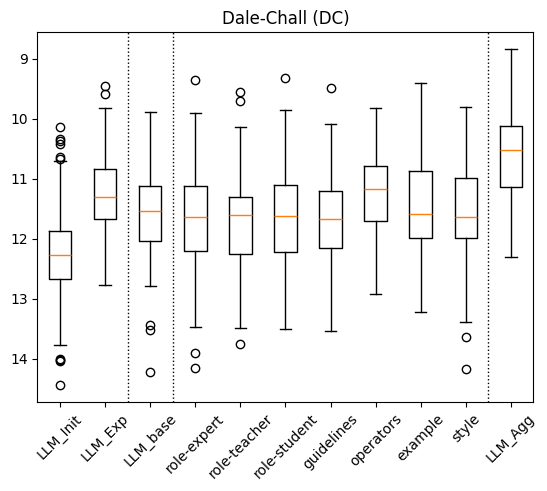

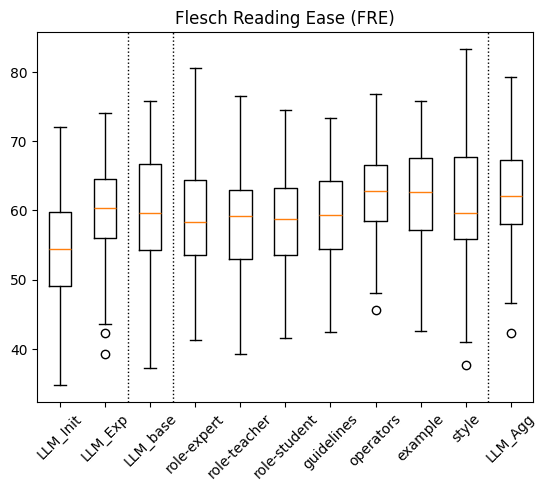

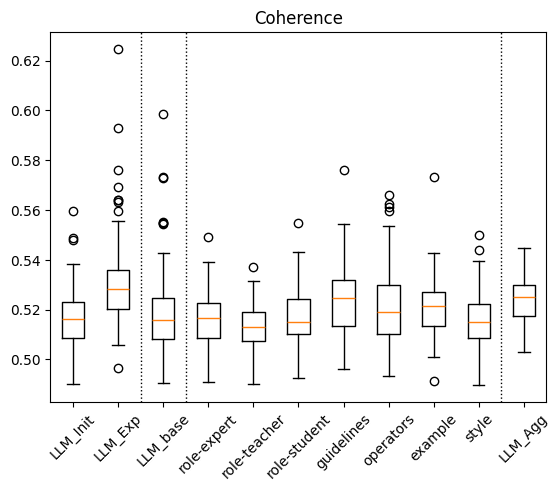

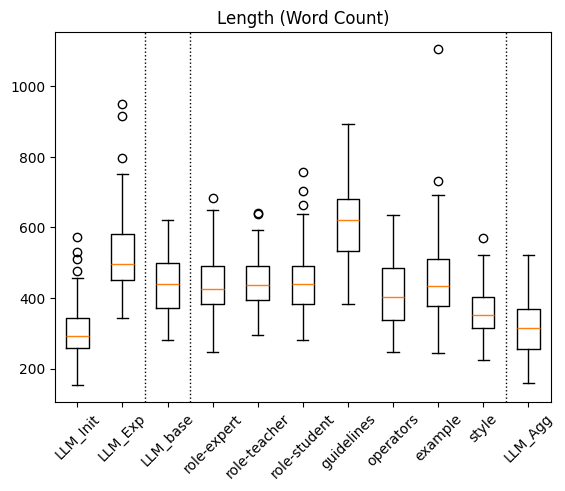

In [ ]:
x = [key[p] for p in prompts]

plt.boxplot(dc)
plt.xticks([i+1 for i in range(len(conditions))], x, rotation=45)
plt.title("Dale-Chall (DC)")
plt.axvline(x=3.5, color="black", linestyle=':', linewidth=1)
plt.axvline(x=2.5, color="black", linestyle=':', linewidth=1)
plt.axvline(x=10.5, color="black", linestyle=':', linewidth=1)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

plt.boxplot(fre)
plt.xticks([i+1 for i in range(len(conditions))], x, rotation=45)
plt.title("Flesch Reading Ease (FRE)")
plt.axvline(x=3.5, color="black", linestyle=':', linewidth=1)
plt.axvline(x=2.5, color="black", linestyle=':', linewidth=1)
plt.axvline(x=10.5, color="black", linestyle=':', linewidth=1)
plt.show()

plt.boxplot(coh)
plt.xticks([i+1 for i in range(len(conditions))], x, rotation=45)
plt.title("Coherence")
plt.axvline(x=3.5, color="black", linestyle=':', linewidth=1)
plt.axvline(x=2.5, color="black", linestyle=':', linewidth=1)
plt.axvline(x=10.5, color="black", linestyle=':', linewidth=1)
plt.show()

plt.boxplot(lengths)
plt.xticks([i+1 for i in range(len(conditions))], x, rotation=45)
plt.title("Length (Word Count)")
plt.axvline(x=3.5, color="black", linestyle=':', linewidth=1)
plt.axvline(x=2.5, color="black", linestyle=':', linewidth=1)
plt.axvline(x=10.5, color="black", linestyle=':', linewidth=1)
plt.show()

Effect of Prompt

In [ ]:
llms = ["R", "L", "M", "I", "O", "Q"]
prompts = ["a", "h"]

In [ ]:
conditions = []
for llm in llms:
  for prompt in prompts:
    conditions.append(llm+prompt)

formulas = ["{:02d}".format(i+1) for i in range(77)]

filenames = np.ndarray((len(formulas), len(conditions)), dtype=object)
files = np.ndarray((len(formulas), len(conditions)), dtype=object)
dc = np.ndarray((len(formulas), len(conditions)))
fre = np.ndarray((len(formulas), len(conditions)))
coh = np.ndarray((len(formulas), len(conditions)))
length = np.ndarray((len(formulas), len(conditions)))

for row in range(filenames.shape[0]):
  print(row)
  for col in range(filenames.shape[1]):
    filenames[row, col] = filepath + formulas[row] + conditions[col] + ".txt"
    if conditions[col][0] in ["O"]:
      files[row, col] = clean(re.sub(r'[^a-zA-Z0-9()|! .:\n]', '', open(filenames[row, col]).read().split(">> gpt 4o low temp:\n")[-1]))
    else:
      files[row, col] = clean(open(filenames[row, col]).read())
    dc[row, col] = ts.dale_chall_readability_score(files[row, col])
    fre[row, col] = ts.flesch_reading_ease(files[row, col])
    coh[row, col] = compute_coherence(files[row, col])
    length[row, col] = len(files[row, col].split())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


In [ ]:
lengths = pd.read_csv(filepath + "metrics/len-llm.csv")
coh = pd.read_csv(filepath + "metrics/coh-llm.csv")
fre = pd.read_csv(filepath + "metrics/fre-llm.csv")
dc = pd.read_csv(filepath + "metrics/dc-llm.csv")

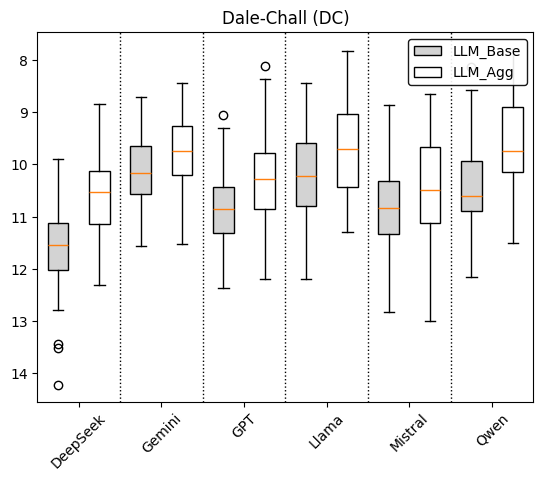

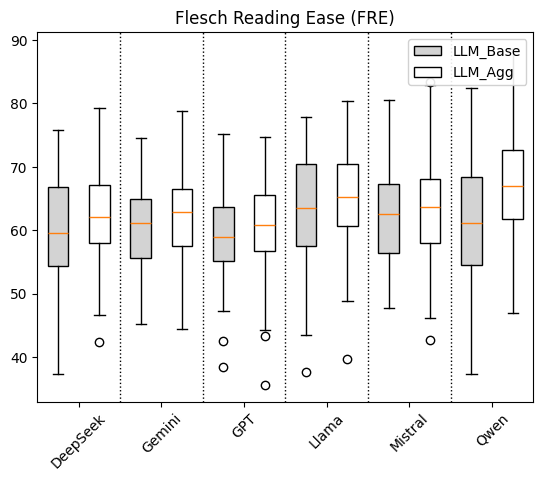

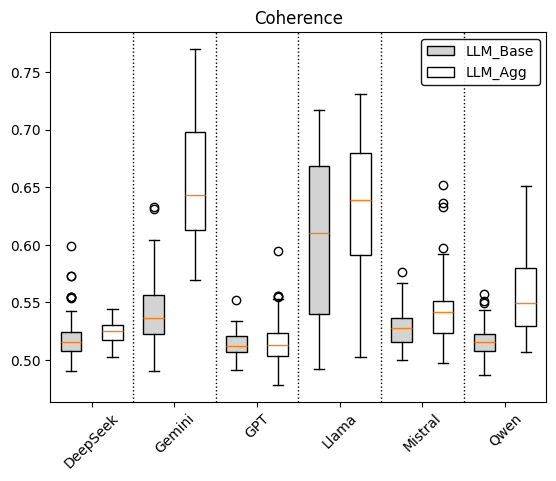

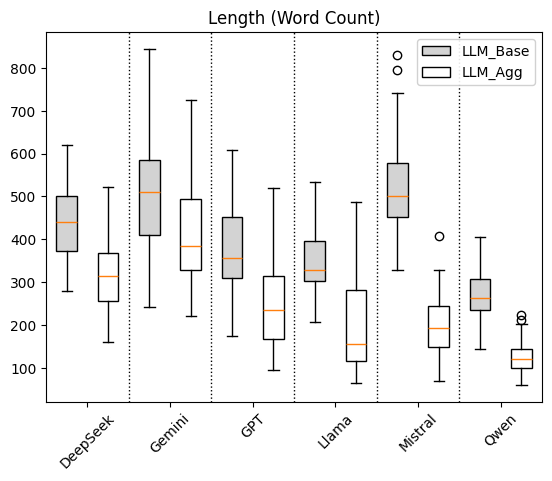

In [ ]:
length = pd.read_csv(filepath + "length-llm.csv")
length = length[["Ra", "Rh", "Ia", "Ih", "Oa", "Oh", "La", "Lh", "Ma", "Mh", "Qa", "Qh"]]
coh = pd.read_csv(filepath + "coh-llm.csv")
coh = coh[["Ra", "Rh", "Ia", "Ih", "Oa", "Oh", "La", "Lh", "Ma", "Mh", "Qa", "Qh"]]
fre = pd.read_csv(filepath + "fre-llm.csv")
fre = fre[["Ra", "Rh", "Ia", "Ih", "Oa", "Oh", "La", "Lh", "Ma", "Mh", "Qa", "Qh"]]
dc = pd.read_csv(filepath + "dc-llm.csv")
dc = dc[["Ra", "Rh", "Ia", "Ih", "Oa", "Oh", "La", "Lh", "Ma", "Mh", "Qa", "Qh"]]

conditions = []
for llm in llms:
  for prompt in prompts:
    conditions.append(llm+prompt)

x = [key[p] for p in llms]
colors = ["lightgray", "white"]
legend_handles = [
    Patch(facecolor='lightgray', edgecolor="black", label='LLM_Base'),
    Patch(facecolor='white', edgecolor="black", label='LLM_Agg')
]

boxplot = plt.boxplot(dc, patch_artist=True)
plt.xticks([2*i+1.5 for i in range(len(llms))], x, rotation=45)
plt.title("Dale-Chall (DC)")
for i in range(len(llms)-1):
  plt.axvline(x=2*i+2.5, color="black", linestyle=':', linewidth=1)
for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor(colors[i % 2])
plt.legend(handles=legend_handles, edgecolor="black", loc='upper right', framealpha=0.9)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

boxplot = plt.boxplot(fre, patch_artist=True)
plt.xticks([2*i+1.5 for i in range(len(llms))], x, rotation=45)
plt.title("Flesch Reading Ease (FRE)")
for i in range(len(llms)-1):
  plt.axvline(x=2*i+2.5, color="black", linestyle=':', linewidth=1)
for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor(colors[i % 2])
plt.legend(handles=legend_handles, loc='upper right', framealpha=0.9)
plt.show()

boxplot = plt.boxplot(coh, patch_artist=True)
plt.xticks([2*i+1.5 for i in range(len(llms))], x, rotation=45)
plt.title("Coherence")
for i in range(len(llms)-1):
  plt.axvline(x=2*i+2.5, color="black", linestyle=':', linewidth=1)
for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor(colors[i % 2])
plt.legend(handles=legend_handles, edgecolor="black", loc='upper right', framealpha=0.9)
plt.show()

boxplot = plt.boxplot(length, patch_artist=True)
plt.xticks([2*i+1.5 for i in range(len(llms))], x, rotation=45)
plt.title("Length (Word Count)")
for i in range(len(llms)-1):
  plt.axvline(x=2*i+2.5, color="black", linestyle=':', linewidth=1)
for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor(colors[i % 2])
plt.legend(handles=legend_handles, loc='upper right', framealpha=0.9)
plt.show()

CSVs

In [ ]:
fre_pd = pd.DataFrame(fre, columns=conditions)
fre_pd.to_csv("/content/drive/MyDrive/fre.csv", index=False)
dc_pd = pd.DataFrame(dc, columns=conditions)
dc_pd.to_csv("/content/drive/MyDrive/dc.csv", index=False)
len_pd = pd.DataFrame(length, columns=conditions)
len_pd.to_csv("/content/drive/MyDrive/len.csv", index=False)
coh_pd = pd.DataFrame(coh, columns=conditions)
coh_pd.to_csv("/content/drive/MyDrive/coh.csv", index=False)

GPT-4o Explanations

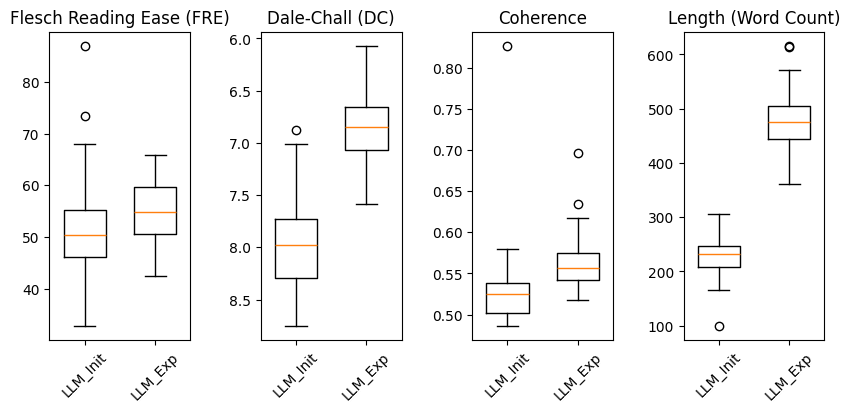

In [ ]:
lengths = pd.read_csv(filepath + "lengths_old_paper.csv")
coh = pd.read_csv(filepath + "coh_old_paper.csv")
fre = pd.read_csv(filepath + "fre_old_paper.csv")
dc = pd.read_csv(filepath + "dc_old_paper.csv")

x = [key[p] for p in lengths.columns]

fig, ax = plt.subplots(1, 4, figsize=(10, 4))

ax[0].boxplot(fre, widths=0.6)
ax[0].set_xticks([i+1 for i in range(len(fre.columns))], x, rotation=45)
ax[0].set_title("Flesch Reading Ease (FRE)")

ax[1].boxplot(dc, widths=0.6)
ax[1].set_xticks([i+1 for i in range(len(dc.columns))], x, rotation=45)
ax[1].set_title("Dale-Chall (DC)")
ax[1].invert_yaxis()

ax[2].boxplot(coh, widths=0.6)
ax[2].set_xticks([i+1 for i in range(len(coh.columns))], x, rotation=45)
ax[2].set_title("Coherence")

ax[3].boxplot(lengths, widths=0.6)
ax[3].set_xticks([i+1 for i in range(len(lengths.columns))], x, rotation=45)
ax[3].set_title("Length (Word Count)")

plt.subplots_adjust(wspace=0.5)
plt.show()

GPT-4o Summaries

/tmp/ipython-input-1192635035.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dc.ssumm.iloc[np.where(dc.ssumm > 15)[0]] = np.nan


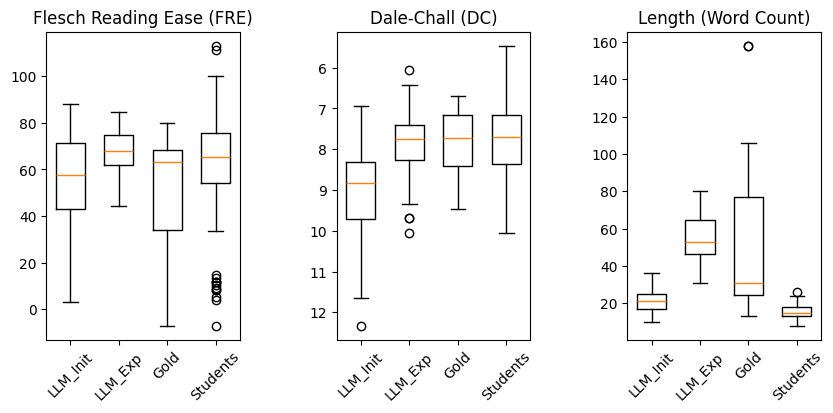

In [ ]:
lengths = pd.read_csv(filepath + "length_old_paper_summ.csv")
fre = pd.read_csv(filepath + "fre_old_paper_summ.csv")
dc = pd.read_csv(filepath + "dc_old_paper_summ.csv")

dc.ssumm.iloc[np.where(dc.ssumm > 15)[0]] = np.nan

x = [key[p] for p in lengths.columns]

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

def drop_nan(df):
  return [df[col].dropna().values for col in df.columns]

ax[0].boxplot(drop_nan(fre), widths=0.6)
ax[0].set_xticks([i+1 for i in range(len(fre.columns))], x, rotation=45)
ax[0].set_title("Flesch Reading Ease (FRE)")

ax[1].boxplot(drop_nan(dc), widths=0.6)
ax[1].set_xticks([i+1 for i in range(len(dc.columns))], x, rotation=45)
ax[1].set_title("Dale-Chall (DC)")
ax[1].invert_yaxis()

ax[2].boxplot(lengths, widths=0.6)
ax[2].set_xticks([i+1 for i in range(len(lengths.columns))], x, rotation=45)
ax[2].set_title("Length (Word Count)")

plt.subplots_adjust(wspace=0.5)
plt.show()

Looking at Stuff

In [ ]:
dc.ssumm.iloc[np.where(dc.ssumm > 15)[0]] = None

/tmp/ipython-input-4224762496.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dc.ssumm.iloc[np.where(dc.ssumm > 15)[0]] = None


In [ ]:
filepath = "/content/drive/MyDrive/Post Bacc/ltl/"
fre = pd.read_csv("/content/drive/MyDrive/Post Bacc/ltl/fre_old_paper_summ.csv")
lengths = pd.read_csv("/content/drive/MyDrive/Post Bacc/ltl/length_old_paper_summ.csv")
dc = pd.read_csv("/content/drive/MyDrive/Post Bacc/ltl/dc_old_paper_summ.csv")

Getting Total Word Count

In [ ]:
prompt = pd.read_csv("/content/drive/MyDrive/Post Bacc/ltl/len-prompt.csv")
llm = pd.read_csv("/content/drive/MyDrive/Post Bacc/ltl/len-llm.csv")

In [ ]:
prompt.head()

,Rllm_org,Rllm_new,Ra,Rb-expert,Rb-hsteacher,Rb-student,Rc,Rd,Re,Rf,Rh
0,315.0,471.0,487.0,510.0,464.0,467.0,583.0,337.0,466.0,427.0,359.0
1,303.0,532.0,410.0,395.0,475.0,383.0,814.0,345.0,528.0,408.0,257.0
2,258.0,443.0,302.0,389.0,336.0,424.0,476.0,301.0,450.0,336.0,233.0
3,343.0,528.0,490.0,389.0,487.0,454.0,524.0,337.0,399.0,315.0,282.0
4,339.0,405.0,419.0,447.0,484.0,371.0,649.0,339.0,474.0,254.0,252.0


In [ ]:
llm.head()

,Ra,Rh,La,Lh,Ma,Mh,Ia,Ih,Oa,Oh,Qa,Qh
0,487.0,359.0,400.0,315.0,501.0,206.0,510.0,364.0,300.0,266.0,341.0,153.0
1,410.0,257.0,350.0,210.0,579.0,203.0,506.0,405.0,290.0,201.0,325.0,88.0
2,302.0,233.0,263.0,145.0,377.0,118.0,432.0,417.0,207.0,258.0,266.0,89.0
3,490.0,282.0,316.0,414.0,538.0,181.0,464.0,440.0,315.0,270.0,365.0,88.0
4,419.0,252.0,373.0,177.0,377.0,190.0,401.0,361.0,237.0,176.0,202.0,142.0


In [ ]:
prompt.sum().sum() + llm.sum().sum() - llm.Ra.sum()-llm.Rh.sum()

np.float64(615911.0)

In [ ]:
llm.sum().sum()

np.float64(304859.0)